<a href="https://colab.research.google.com/github/AlkaidCheng/GSOC_MLHEP/blob/master/Variational_Quantum_Classifier_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Quantum Classifier
- Step 1: Prepare training data and perform data preprocessing
- Step 2: Construct encoding circuit
- Step 3: Construct variational circuit
- Step 4: Build the VQC model with the encoding circuit as input layer, variational circuit as pqc layer and an output layer with a custom activation function
- Step 5: Decide on the optimizer, the loss function, the evaluation metrics and callbacks for training
- Step 6: Train the classifier
- Step 7: Evaluate the result

###Install dependencies

In [1]:
#this will also install tensorflow==2.1.0 and tensorflow_quantum
!pip install  quple

     |████████████████████████████████| 3.9MB 9.4MB/s 
     |████████████████████████████████| 421.8MB 34kB/s 
     |████████████████████████████████| 1.4MB 20.7MB/s 
     |████████████████████████████████| 163kB 44.0MB/s 
     |████████████████████████████████| 5.3MB 39.8MB/s 
     |████████████████████████████████| 450kB 39.1MB/s 
     |████████████████████████████████| 3.9MB 40.3MB/s 
     |████████████████████████████████| 112kB 36.6MB/s 
     |████████████████████████████████| 133kB 35.4MB/s 
  Created wheel for pathos: filename=pathos-0.2.5-cp36-none-any.whl size=77577 sha256=4a8dd75fff709b71513ccdaf69e7e6f2c4af84202dd4e9a1c59292fb67c3d624
  Stored in directory: /root/.cache/pip/wheels/61/6d/83/90b0c3d2c271da2c4850731e894798c98f8dbedbac74e8eff0
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=629e6ed38bf1d876e58718d70e29609015cc03896953f2a91a7d9b3e882f9ed1
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699fe

 ## Step 1: Prepare Training Data and Perform Data Preprocessing

In [2]:
# download training data (hmumu 2jet)
!wget -O hmumu_2jet.tar.gz https://cernbox.cern.ch/index.php/s/frrpvyVfSPYdMSk/download
!tar -zxf hmumu_2jet.tar.gz

--2020-07-27 19:18:35--  https://cernbox.cern.ch/index.php/s/frrpvyVfSPYdMSk/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.32.38, 128.142.32.26, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1648491 (1.6M) [application/gzip]
Saving to: ‘hmumu_2jet.tar.gz’

hmumu_2jet.tar.gz   100%[===================>]   1.57M  1.42MB/s    in 1.1s    

Last-modified header invalid -- time-stamp ignored.
2020-07-27 19:18:38 (1.42 MB/s) - ‘hmumu_2jet.tar.gz’ saved [1648491/1648491]



In [3]:
import numpy as np
# prepare training data
data = np.load('hmumu_twojet_0719.npy')
x = data[:,:-1]
y = data[:,-1]
print('x:\n', x)
print('y:\n', y)

x:
 [[ 1.35123826e+02  9.97897017e-01  9.58638570e-01 ...  4.58769383e-01
  -3.05654504e+00  1.80854129e+03]
 [ 2.43290406e+02  3.03747750e-01  6.74568519e-01 ... -1.34468994e+00
  -2.72506172e+00  5.11933555e+02]
 [ 1.64464537e+02 -5.81922591e-02  5.42151745e-02 ... -6.23148328e-01
   3.07514485e+00  3.44958465e+02]
 ...
 [ 2.16542712e+01 -3.05524425e+00  4.59151309e-01 ...  9.26630829e-01
   3.08020790e+00  5.62347204e+02]
 [ 4.19387585e+01  1.89239955e+00  4.48033832e-01 ...  1.73410377e+00
  -2.62992120e+00  1.44320990e+02]
 [ 9.33202609e+01  8.70685882e-01  8.74988118e-01 ... -1.21892943e+00
   2.85587492e+00  2.03240716e+02]]
y:
 [1. 1. 1. ... 0. 0. 0.]


In [4]:
# let's say we want to train on a circuit with 5 qubit
n_qubit = 5
# let's say we want to train on 1000 events
n_event = 1000

In [5]:
# prepare data preprocessors from sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
# we apply 3 data preprocessors
# 1. PCA to reduce the dimension to 5 to fit the 5 qubit circuit
# 2. StandardScaler to standardize features by removing the mean and scaling to unit variance
# 3. MinMaxScaler to bound the data in the range [-1,+1]
preprocessors = [PCA(n_components=n_qubit, random_state=3), StandardScaler(), MinMaxScaler((-1,1))]

In [6]:
from quple.components.data_preparation import prepare_train_val_test
# split the data into training set, validation set and test set
x_train, x_val, x_test, y_train, y_val, y_test = prepare_train_val_test(x, y, train_size=n_event, val_size=n_event, test_size=n_event, preprocessors=preprocessors, random_state=24)
print('x_train:\n', x_train)
print('y_train:\n', y_train)
print('x_val:\n', x_val)
print('y_val:\n', y_val)
print('x_test:\n', x_test)
print('y_test:\n', y_test)

x_train:
 [[-8.79408431e-01 -2.91849404e-01 -7.06406980e-01 -1.50171968e-01
  -1.47083778e-01]
 [-6.85069866e-01 -5.15238276e-01 -7.45426413e-01 -1.49557330e-01
  -2.77217974e-01]
 [-9.65548075e-01 -5.41138509e-01 -7.17157856e-01  5.28963334e-02
  -2.94952005e-01]
 ...
 [-8.05304035e-01 -5.60343372e-01 -7.32252537e-01  1.18326216e-01
  -3.20379264e-01]
 [-8.28134277e-01 -5.54357138e-01 -4.72595477e-01  1.14451725e-01
  -2.63482577e-01]
 [-9.30681340e-01 -7.04202429e-01 -5.31064503e-01 -5.78536766e-04
  -2.29519358e-01]]
y_train:
 [1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 0

## Step 2: Construct Encoding Circuit

In [7]:
from quple.data_encoding.first_order_expansion import FirstOrderExpansion
from quple.data_encoding.second_order_expansion import SecondOrderExpansion
from quple.data_encoding.encoding_maps import self_product, cosine_product, modified_cosine_product, distance_measure, arithmetic_mean

In [8]:
# let's try the first order expansion encoding circuit with depth 2
encoding_circuit = FirstOrderExpansion(feature_dimension=n_qubit, copies=2)
encoding_circuit

(0, 0): ───H───Rz(pi*<1.0*x_0>)───H───Rz(pi*<1.0*x_0>)───

(0, 1): ───H───Rz(pi*<1.0*x_1>)───H───Rz(pi*<1.0*x_1>)───

(0, 2): ───H───Rz(pi*<1.0*x_2>)───H───Rz(pi*<1.0*x_2>)───

(0, 3): ───H───Rz(pi*<1.0*x_3>)───H───Rz(pi*<1.0*x_3>)───

(0, 4): ───H───Rz(pi*<1.0*x_4>)───H───Rz(pi*<1.0*x_4>)───

## Step 3: Construct Variational Circuit

In [9]:
from quple.trial_wavefunction.efficient_su2 import EfficientSU2
from quple.trial_wavefunction.real_amplitudes import RealAmplitudes

In [10]:
# let's try the Efficient SU2 variational circuit with depth 2
variational_circuit = EfficientSU2(n_qubit=n_qubit, copies=2)
variational_circuit

┌──┐       ┌──┐                                             ┌──┐       ┌──┐
(0, 0): ───Ry(θ_0)───Rz(θ_5)───@───@───@────@────────────────────────Ry(θ_10)───Rz(θ_15)───@───@───@────@────────────────────────
                               │   │   │    │                                              │   │   │    │
(0, 1): ───Ry(θ_1)───Rz(θ_6)───X───┼───┼────┼@────@────@─────────────Ry(θ_11)───Rz(θ_16)───X───┼───┼────┼@────@────@─────────────
                                   │   │    ││    │    │                                       │   │    ││    │    │
(0, 2): ───Ry(θ_2)───Rz(θ_7)───────X───┼────┼X────┼────┼@────@───────Ry(θ_12)───Rz(θ_17)───────X───┼────┼X────┼────┼@────@───────
                                       │    │     │    ││    │                                     │    │     │    ││    │
(0, 3): ───Ry(θ_3)───Rz(θ_8)───────────X────┼─────X────┼X────┼───@───Ry(θ_13)───Rz(θ_18)───────────X────┼─────X────┼X────┼───@───
                                            │          │     │   │                                      │          │     │   │
(0, 4): ───Ry(θ_4)───Rz(θ_9)────────────────X──────────X─────X───X───Ry(θ_14)───Rz(θ_19)────────────────X──────────X─────X───X───
                                           └──┘       └──┘                                             └──┘       └──┘

## Step 4 and 5: Build the VQC Model

In [11]:
from quple.classifiers.variational_quantum_classifier import VQC
import tensorflow as tf

In [12]:
# let's use the following settings
# output layer activation = sigmoid
# optimizer = Adam
# metrics = binary accuracy and auc
# loss = mean squared loss

# construct the vqc model
vqc = VQC(encoding_circuit, variational_circuit, activation='sigmoid',
          optimizer=tf.keras.optimizers.Adam(), metrics=['binary_accuracy','AUC'], loss='binary_crossentropy', random_state=16)

Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 20


## Step 6: Train the Classifier

In [13]:
# train the vqc moel
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
qnn_history = vqc.fit(
            x_train, y_train,
            batch_size=64,
            epochs=100,
            verbose=1,
            validation_data=(x_val, y_val),
            callbacks=[callback])

Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 12s 12ms/sample - loss: 0.7411 - binary_accuracy: 0.4190 - AUC: 0.2897 - val_loss: 0.7367 - val_binary_accuracy: 0.4170 - val_AUC: 0.3104
Epoch 2/100
1000/1000 [==============================] - 9s 9ms/sample - loss: 0.7351 - binary_accuracy: 0.4150 - AUC: 0.3089 - val_loss: 0.7301 - val_binary_accuracy: 0.4120 - val_AUC: 0.3306
Epoch 3/100
1000/1000 [==============================] - 9s 9ms/sample - loss: 0.7294 - binary_accuracy: 0.4050 - AUC: 0.3262 - val_loss: 0.7242 - val_binary_accuracy: 0.4100 - val_AUC: 0.3516
Epoch 4/100
1000/1000 [==============================] - 9s 9ms/sample - loss: 0.7242 - binary_accuracy: 0.4030 - AUC: 0.3495 - val_loss: 0.7192 - val_binary_accuracy: 0.4090 - val_AUC: 0.3770
Epoch 5/100
1000/1000 [==============================] - 9s 9ms/sample - loss: 0.7200 - binary_accuracy: 0.3970 - AUC: 0.3628 - val_loss: 0.7139 - val_binary_accuracy: 0.4050 - v

## Step 7: Evaluate the Result

In [14]:
# test the model
results = vqc.evaluate(x_test, y_test)
results

1000/1000 [==============================] - 1s 1ms/sample - loss: 0.5125 - binary_accuracy: 0.7630 - AUC: 0.8485


[0.5124844198226929, 0.763, 0.84848857]

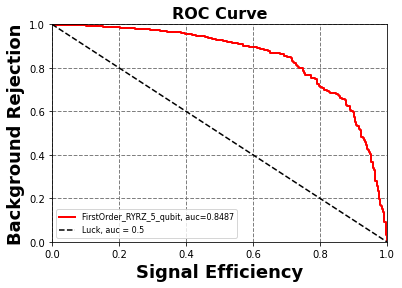

In [15]:
import quple
# plot a roc curve
fpr, tpr, _ = vqc.roc_curve(x_test, y_test)
plt = quple.utils.utils.plot_roc_curve(fpr, tpr, label='FirstOrder_RYRZ_5_qubit')

## Try Different Encoding Circuits

In [16]:
# Try out different encoding maps and using SecondOrderExpansion encoding circuit
# encoding map = self_product ~ x_0*x_1*x_2...
second_order_self_product = SecondOrderExpansion(feature_dimension=n_qubit, encoding_map=self_product, entangle_strategy='linear')
second_order_self_product

(0, 0): ───H───Rz(pi*<1.0*x_0>)───@──────────────────────────@────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*<1.0*x_0>)───@──────────────────────────@────────────────────────────────────────────────────────────────────────────────────────────────
                                  │                          │                                                                                                                       │                          │
(0, 1): ───H───Rz(pi*<1.0*x_1>)───X───Rz(pi*<1.0*x_0*x_1>)───X───@──────────────────────────@─────────────────────────────────────────────────────────────────H───Rz(pi*<1.0*x_1>)───X───Rz(pi*<1.0*x_0*x_1>)───X───@──────────────────────────@─────────────────────────────────────────────────────────────────
                                                                 │                          │                                                                                                                       │                          │
(0, 2): ───H───Rz(pi*<1.0*x_2>)──────────────────────────────────X───Rz(pi*<1.0*x_1*x_2>)───X───@──────────────────────────@──────────────────────────────────H───Rz(pi*<1.0*x_2>)──────────────────────────────────X───Rz(pi*<1.0*x_1*x_2>)───X───@──────────────────────────@──────────────────────────────────
                                                                                                │                          │                                                                                                                       │                          │
(0, 3): ───H───Rz(pi*<1.0*x_3>)─────────────────────────────────────────────────────────────────X───Rz(pi*<1.0*x_2*x_3>)───X───@──────────────────────────@───H───Rz(pi*<1.0*x_3>)─────────────────────────────────────────────────────────────────X───Rz(pi*<1.0*x_2*x_3>)───X───@──────────────────────────@───
                                                                                                                               │                          │                                                                                                                       │                          │
(0, 4): ───H───Rz(pi*<1.0*x_4>)────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<1.0*x_3*x_4>)───X───H───Rz(pi*<1.0*x_4>)────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<1.0*x_3*x_4>)───X───

In [17]:
# encoding map = cosine_product ~ cos(x_0)*cos(x_1)*...
second_order_cosine_product = SecondOrderExpansion(feature_dimension=n_qubit, encoding_map=cosine_product, entangle_strategy='linear')
second_order_cosine_product

(0, 0): ───H───Rz(pi*<1.0*cos(pi*x_0)>)───@──────────────────────────────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*<1.0*cos(pi*x_0)>)───@──────────────────────────────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                          │                                          │                                                                                                                                                                               │                                          │
(0, 1): ───H───Rz(pi*<1.0*cos(pi*x_1)>)───X───Rz(pi*<1.0*cos(pi*x_0)*cos(pi*x_1)>)───X───@──────────────────────────────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*<1.0*cos(pi*x_1)>)───X───Rz(pi*<1.0*cos(pi*x_0)*cos(pi*x_1)>)───X───@──────────────────────────────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                         │                                          │                                                                                                                                                                               │                                          │
(0, 2): ───H───Rz(pi*<1.0*cos(pi*x_2)>)──────────────────────────────────────────────────X───Rz(pi*<1.0*cos(pi*x_1)*cos(pi*x_2)>)───X───@──────────────────────────────────────────@──────────────────────────────────────────────────H───Rz(pi*<1.0*cos(pi*x_2)>)──────────────────────────────────────────────────X───Rz(pi*<1.0*cos(pi*x_1)*cos(pi*x_2)>)───X───@──────────────────────────────────────────@──────────────────────────────────────────────────
                                                                                                                                        │                                          │                                                                                                                                                                               │                                          │
(0, 3): ───H───Rz(pi*<1.0*cos(pi*x_3)>)─────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<1.0*cos(pi*x_2)*cos(pi*x_3)>)───X───@──────────────────────────────────────────@───H───Rz(pi*<1.0*cos(pi*x_3)>)─────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<1.0*cos(pi*x_2)*cos(pi*x_3)>)───X───@──────────────────────────────────────────@───
                                                                                                                                                                                       │                                          │                                                                                                                                                                               │                                          │
(0, 4): ───H───Rz(pi*<1.0*cos(pi*x_4)>)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<1.0*cos(pi*x_3)*cos(pi*x_4)>)───X───H───Rz(pi*<1.0*cos(pi*x_4)>)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<1.0*cos(pi*x_3)*cos(pi*x_4)>)───X───

In [18]:
# encoding map = distance_measure ~ (x_0-x_1)*(x_1-x_2)*(x_2-x_3)/2**(number of pairs)...
second_order_distance_measure = SecondOrderExpansion(feature_dimension=n_qubit, encoding_map=distance_measure, entangle_strategy='linear')
second_order_distance_measure

(0, 0): ───H───Rz(pi*<1.0*x_0>)───@────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*<1.0*x_0>)───@────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                  │                                │                                                                                                                                         │                                │
(0, 1): ───H───Rz(pi*<1.0*x_1>)───X───Rz(pi*<0.5*x_0 - 0.5*x_1>)───X───@────────────────────────────────@─────────────────────────────────────────────────────────────────────────────H───Rz(pi*<1.0*x_1>)───X───Rz(pi*<0.5*x_0 - 0.5*x_1>)───X───@────────────────────────────────@─────────────────────────────────────────────────────────────────────────────
                                                                       │                                │                                                                                                                                         │                                │
(0, 2): ───H───Rz(pi*<1.0*x_2>)────────────────────────────────────────X───Rz(pi*<0.5*x_1 - 0.5*x_2>)───X───@────────────────────────────────@────────────────────────────────────────H───Rz(pi*<1.0*x_2>)────────────────────────────────────────X───Rz(pi*<0.5*x_1 - 0.5*x_2>)───X───@────────────────────────────────@────────────────────────────────────────
                                                                                                            │                                │                                                                                                                                         │                                │
(0, 3): ───H───Rz(pi*<1.0*x_3>)─────────────────────────────────────────────────────────────────────────────X───Rz(pi*<0.5*x_2 - 0.5*x_3>)───X───@────────────────────────────────@───H───Rz(pi*<1.0*x_3>)─────────────────────────────────────────────────────────────────────────────X───Rz(pi*<0.5*x_2 - 0.5*x_3>)───X───@────────────────────────────────@───
                                                                                                                                                 │                                │                                                                                                                                         │                                │
(0, 4): ───H───Rz(pi*<1.0*x_4>)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<0.5*x_3 - 0.5*x_4>)───X───H───Rz(pi*<1.0*x_4>)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<0.5*x_3 - 0.5*x_4>)───X───

In [19]:
# encoding map = arithmetic_mean ~ (x_0+x_1+x_2+...)/N...
second_order_arithmetic_mean = SecondOrderExpansion(feature_dimension=n_qubit, encoding_map=arithmetic_mean, entangle_strategy='linear')
second_order_arithmetic_mean

(0, 0): ───H───Rz(pi*<1.0*x_0>)───@────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*<1.0*x_0>)───@────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                  │                                │                                                                                                                                         │                                │
(0, 1): ───H───Rz(pi*<1.0*x_1>)───X───Rz(pi*<0.5*x_0 + 0.5*x_1>)───X───@────────────────────────────────@─────────────────────────────────────────────────────────────────────────────H───Rz(pi*<1.0*x_1>)───X───Rz(pi*<0.5*x_0 + 0.5*x_1>)───X───@────────────────────────────────@─────────────────────────────────────────────────────────────────────────────
                                                                       │                                │                                                                                                                                         │                                │
(0, 2): ───H───Rz(pi*<1.0*x_2>)────────────────────────────────────────X───Rz(pi*<0.5*x_1 + 0.5*x_2>)───X───@────────────────────────────────@────────────────────────────────────────H───Rz(pi*<1.0*x_2>)────────────────────────────────────────X───Rz(pi*<0.5*x_1 + 0.5*x_2>)───X───@────────────────────────────────@────────────────────────────────────────
                                                                                                            │                                │                                                                                                                                         │                                │
(0, 3): ───H───Rz(pi*<1.0*x_3>)─────────────────────────────────────────────────────────────────────────────X───Rz(pi*<0.5*x_2 + 0.5*x_3>)───X───@────────────────────────────────@───H───Rz(pi*<1.0*x_3>)─────────────────────────────────────────────────────────────────────────────X───Rz(pi*<0.5*x_2 + 0.5*x_3>)───X───@────────────────────────────────@───
                                                                                                                                                 │                                │                                                                                                                                         │                                │
(0, 4): ───H───Rz(pi*<1.0*x_4>)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<0.5*x_3 + 0.5*x_4>)───X───H───Rz(pi*<1.0*x_4>)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(pi*<0.5*x_3 + 0.5*x_4>)───X───

In [20]:
# construct the models with the various encoding circuits
my_models = [
  VQC(second_order_self_product, variational_circuit, metrics=['binary_accuracy','AUC'], loss='binary_crossentropy', random_state=16),
  VQC(second_order_cosine_product, variational_circuit, metrics=['binary_accuracy','AUC'], loss='binary_crossentropy', random_state=16),
  VQC(second_order_distance_measure, variational_circuit, metrics=['binary_accuracy','AUC'], loss='binary_crossentropy', random_state=16),
  VQC(second_order_arithmetic_mean, variational_circuit, metrics=['binary_accuracy','AUC'], loss='binary_crossentropy', random_state=16)
]

Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 20
Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 20
Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 20
Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 20


In [21]:
# create the tensor form of the resolved encoding circuits (this can be feeded to model.fit directly so that the conversion does not happen inside fit)
x_train_tensors = [model.convert_to_tensor(x_train) for model in my_models]
x_val_tensors = [model.convert_to_tensor(x_val) for model in my_models]
x_test_tensors = [model.convert_to_tensor(x_test) for model in my_models]

In [22]:
# train the models
for i,model in enumerate(my_models):
  model.fit(
    x_train_tensors[i], y_train,
    batch_size=64,
    epochs=100,
    verbose=1,
    validation_data=(x_val_tensors[i], y_val),
    callbacks=[callback])

Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 14s 14ms/sample - loss: 0.6954 - binary_accuracy: 0.5340 - AUC: 0.5547 - val_loss: 0.6913 - val_binary_accuracy: 0.5580 - val_AUC: 0.5765
Epoch 2/100
1000/1000 [==============================] - 13s 13ms/sample - loss: 0.6920 - binary_accuracy: 0.5460 - AUC: 0.5838 - val_loss: 0.6880 - val_binary_accuracy: 0.5670 - val_AUC: 0.6064
Epoch 3/100
1000/1000 [==============================] - 14s 14ms/sample - loss: 0.6889 - binary_accuracy: 0.5520 - AUC: 0.6076 - val_loss: 0.6846 - val_binary_accuracy: 0.5780 - val_AUC: 0.6305
Epoch 4/100
1000/1000 [==============================] - 14s 14ms/sample - loss: 0.6860 - binary_accuracy: 0.5670 - AUC: 0.6288 - val_loss: 0.6814 - val_binary_accuracy: 0.6000 - val_AUC: 0.6498
Epoch 5/100
1000/1000 [==============================] - 13s 13ms/sample - loss: 0.6829 - binary_accuracy: 0.5760 - AUC: 0.6446 - val_loss: 0.6783 - val_binary_accuracy: 0.

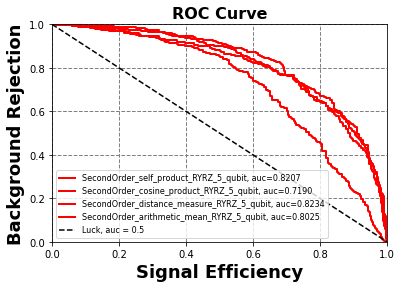

In [23]:
# plot the roc curves
fpr_list, tpr_list = [], []
for i,model in enumerate(my_models):
  fpr, tpr, _ = model.roc_curve(x_test_tensors[i], y_test)
  fpr_list.append(fpr)
  tpr_list.append(tpr)
labels = ['SecondOrder_self_product_RYRZ_5_qubit',
          'SecondOrder_cosine_product_RYRZ_5_qubit',
          'SecondOrder_distance_measure_RYRZ_5_qubit',
          'SecondOrder_arithmetic_mean_RYRZ_5_qubit']
multi_model_plt = quple.utils.utils.plot_stacked_roc_curve(fpr_list, tpr_list, labels)